## Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.stats
import dynesty
import corner
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc


plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[7,5]

### Data

Load the transient data

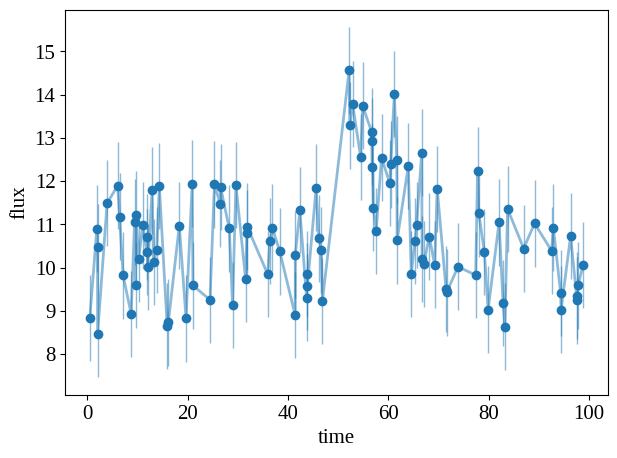

In [2]:
data=np.load('transient.npy')

time=data[:,0]
flux=data[:,1]
err=data[:,2]

plt.scatter(time, flux)
plt.errorbar(time, flux, err, lw=2, elinewidth=1, alpha=0.5)
plt.xlabel("time")
plt.ylabel("flux")
plt.show()

### Burst model

Define the burst model:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

the prior of the burst parameters and the Likelihood, then run the Nested Sampling algorithm.

In [3]:
ndim=4

def burst(par, time):
    b, A, t_0, alpha = par
    y=np.empty(len(time))
    for i in range(len(time)):
        if time[i]<t_0:
            y[i]=b
        else:
            y[i]=b + A * np.exp(-alpha*(time[i]-t_0)) 
    return y

In [4]:
def prior_burst(u):         
    b = u[0]*50           
    A = u[1]*50                # A, b from uniform(0,50)    
    t_0 = u[2]*100              # to from uniform(0,100)    
    alpha = scipy.stats.loguniform.ppf(u[3], np.exp(-5), np.exp(5))     # alpha from uniform(e^-5, e^5)
    
    par = np.array([b, A, t_0, alpha])   
    return(par)

def loglike_burst(par, time, flux, err):
    b, A, t_0, alpha = par
    model_burst = burst(par, time)
    return - 0.5 * np.sum((flux-model_burst)**2/(err**2))

In [5]:
sampler_burst = dynesty.NestedSampler(loglike_burst, prior_burst, ndim, logl_args=[time, flux, err])
sampler_burst.run_nested()
result_burst = sampler_burst.results

7702it [01:16, 101.21it/s, +500 | bound: 149 | nc: 1 | ncall: 139116 | eff(%):  5.917 | loglstar:   -inf < -48.759 <    inf | logz: -63.371 +/-  0.168 | dlogz:  0.001 >  0.509]


Let's have a check if everything converged as we expect.

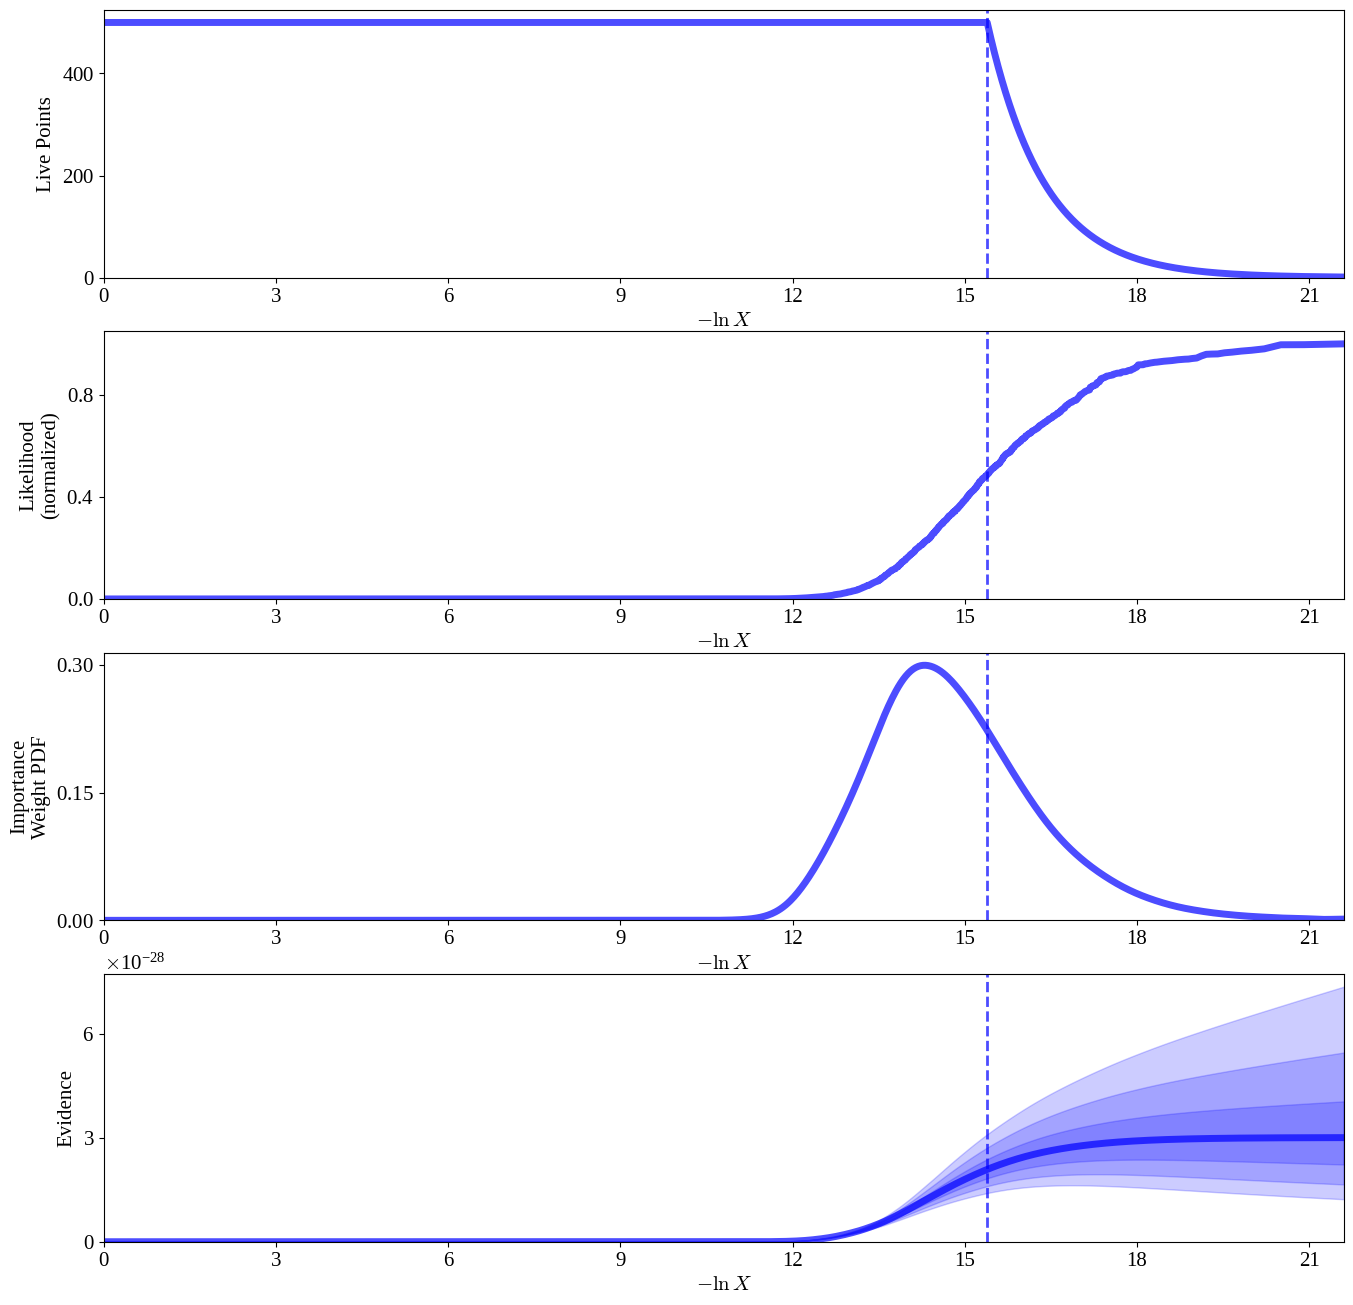

In [6]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(result_burst)

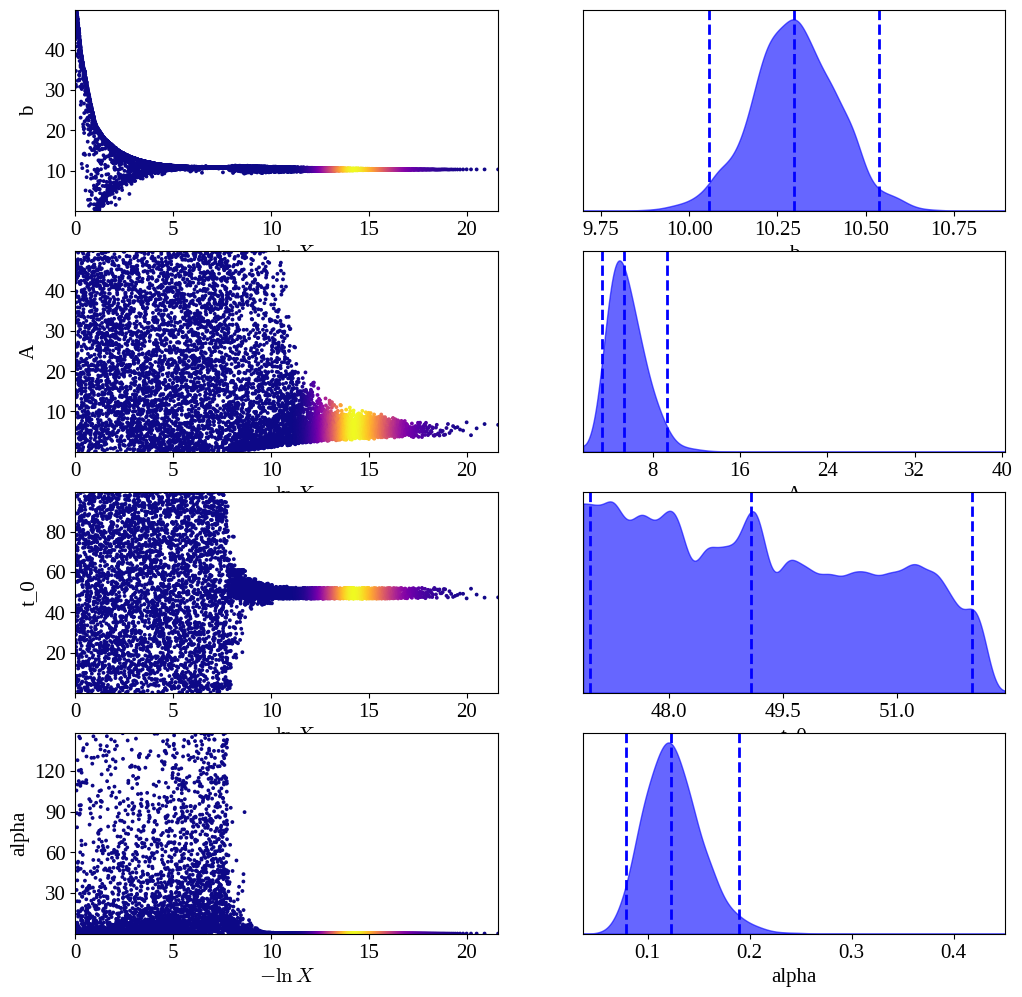

In [7]:
labels_burst = ["b","A","t_0","alpha"]

tfig, taxes = dyplot.traceplot(result_burst, labels=labels_burst)

All the four parameters converged. Re-weight the samples according to the result and then check the distributions obtained.

In [8]:
samples_burst = result_burst.samples
weights_burst = np.exp(result_burst.logwt - result_burst.logz[-1])

samples_eq_burst = dyfunc.resample_equal(samples_burst, weights_burst)

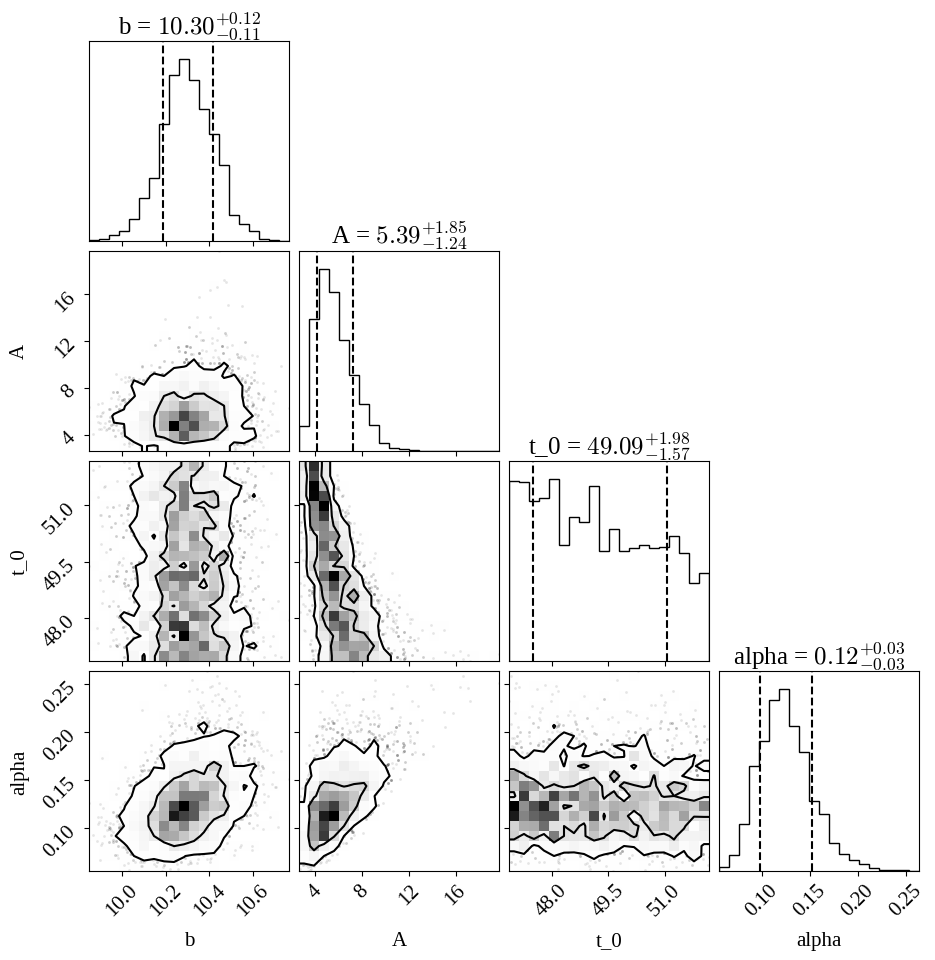

In [9]:
fig = corner.corner(samples_eq_burst, labels=labels_burst, levels=[0.68,0.95], quantiles=[0.16, 0.84], 
                    show_titles=True)

In [10]:
quantiles_burst = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights_burst)
             for samps in samples_burst.T]
for q,l in zip(quantiles_burst,labels_burst):
    low,med,up=q
    print(l,"=",str(round(med,2)),"+",str(round(up-med,2)),"-",str(round(med-low,2)))

b = 10.3 + 0.19 - 0.2
A = 5.38 + 3.3 - 1.8
t_0 = 49.09 + 2.67 - 2.03
alpha = 0.12 + 0.05 - 0.04


We obtained the values of the parameters with the relative errors.

### Gaussian model

Let's consider another model to describe our data, in particular a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Let's start by fitting *by hand* the model to the data.

In [11]:
# Gaussian model

def gauss_model(par, time):
    b, A, t_0, sigma = par 
    return b+A*np.exp(-(((time-t_0)/sigma)**2 ) / 2)

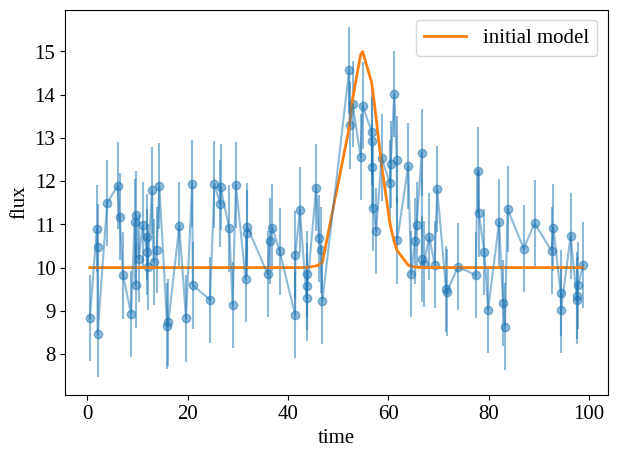

In [59]:
#fit the data with the gaussian model to find reasonable priors

b, A, t_0, sigma = 10, 5, 55, 3
par = [b, A, t_0, sigma]

flux_model_gauss = gauss_model(par, time)

plt.scatter(time, flux, alpha=0.5)
plt.errorbar(time, flux, err, alpha=0.5)
plt.plot(time, flux_model_gauss, label='initial model', lw=2)
plt.legend()
plt.ylabel('flux')
plt.xlabel('time')
plt.show()

Define the priors, the Likelihood and run the sampler with the gaussian model.

In [13]:
def prior_gauss(u):         
    b = u[0]*50           
    A = u[1]*50                # A, b from uniform(0,50)    
    t_0 = u[2]*100              # to from uniform(0,100)    
    sigma = scipy.stats.loguniform.ppf(u[3], np.exp(-2), np.exp(2))     # ln(sigma) from uniform(-2, 2)
    
    par = np.array([b, A, t_0, sigma])   
    return(par)

def loglike_gauss(par, time, flux, err):
    b, A, t_0, sigma = par
    model_gauss = gauss_model(par, time)
    return - 0.5 * np.sum((flux-model_gauss)**2/(err**2))

In [14]:
sampler_gauss = dynesty.NestedSampler(loglike_gauss, prior_gauss, ndim, logl_args=[time, flux, err])
sampler_gauss.run_nested()
result_gauss = sampler_gauss.results

7940it [00:50, 155.72it/s, +500 | bound: 117 | nc: 1 | ncall: 112358 | eff(%):  7.545 | loglstar:   -inf < -52.429 <    inf | logz: -67.580 +/-  0.173 | dlogz:  0.001 >  0.509]


Check if everything converged.

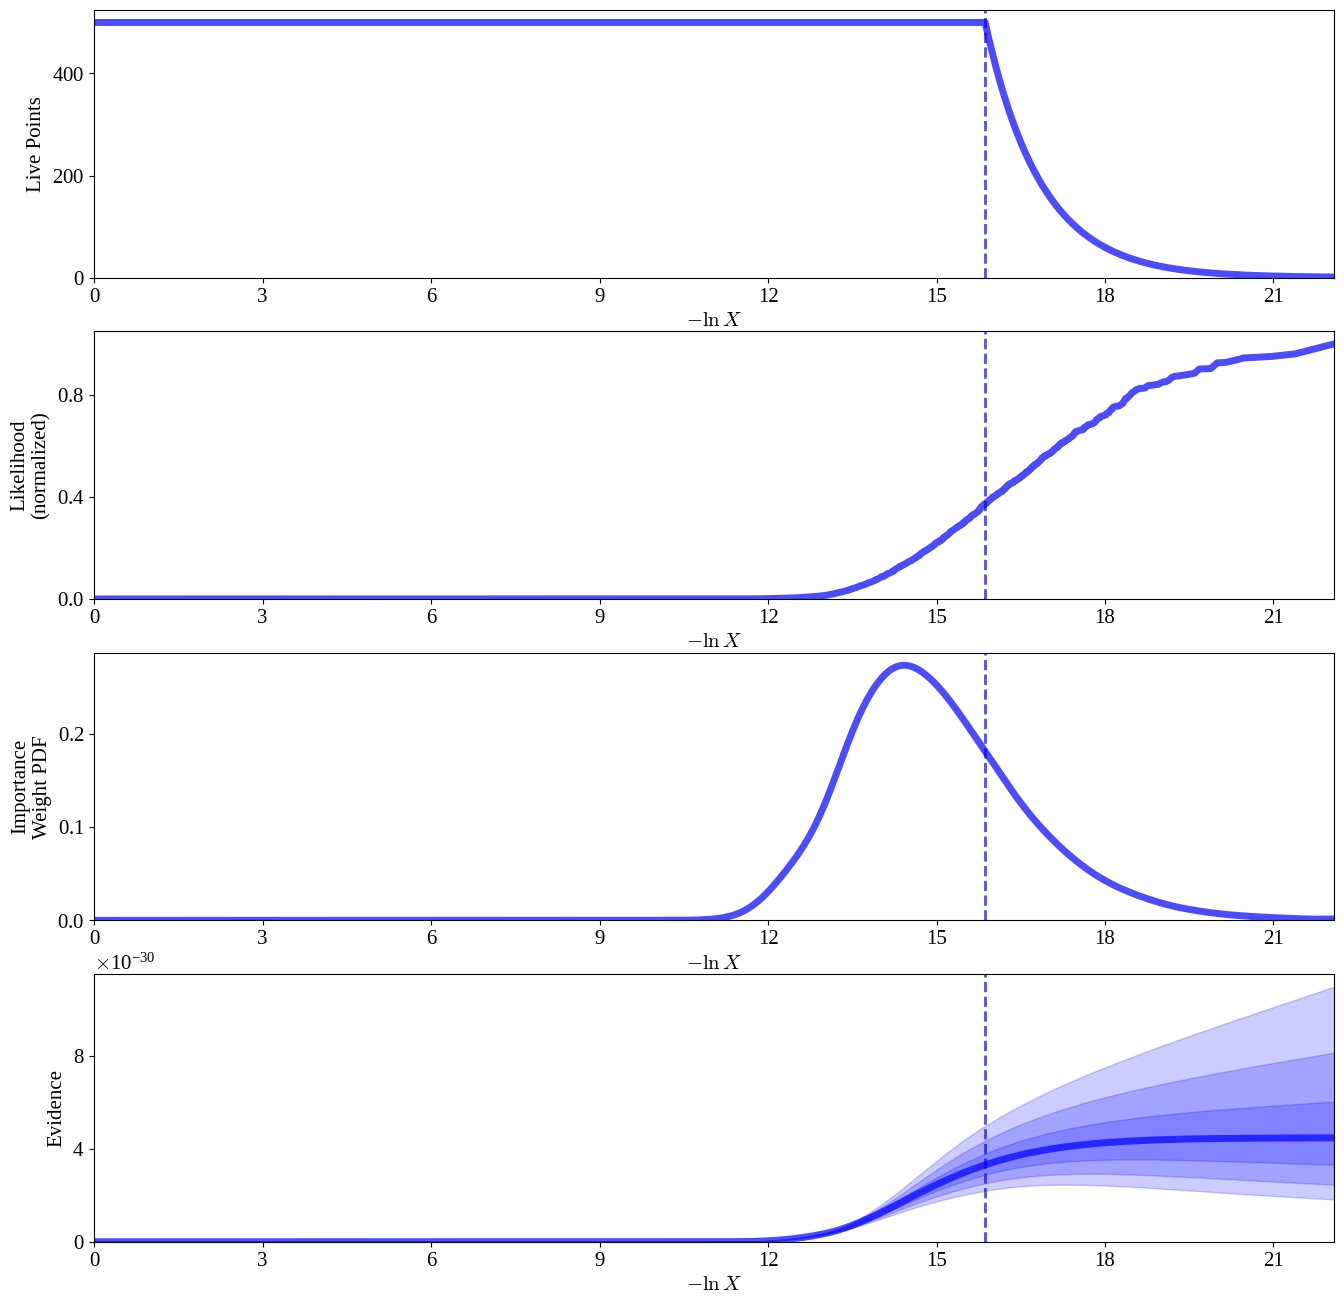

In [15]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(result_gauss)

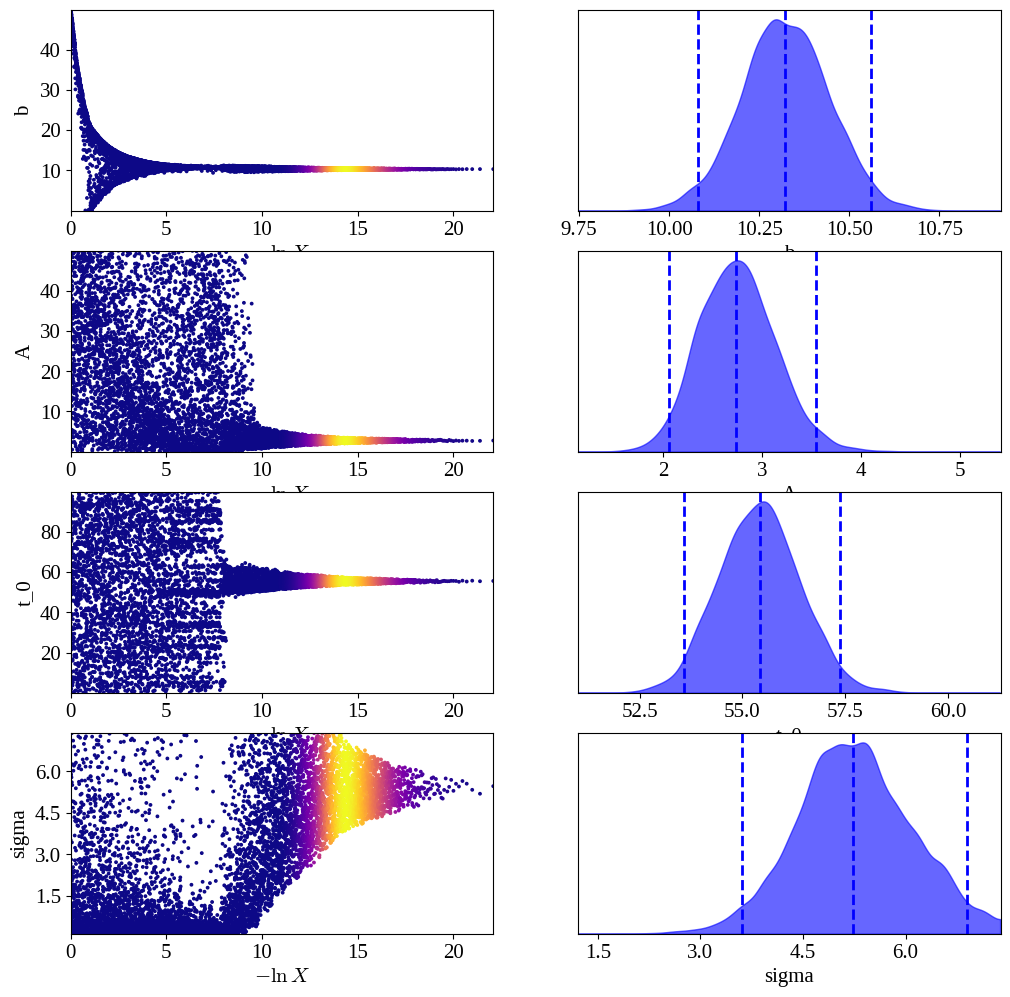

In [16]:
labels_gauss = ["b","A","t_0","sigma"]

tfig, taxes = dyplot.traceplot(result_gauss, labels=labels_gauss)

And plot the distributions that we obtained for the parameters of the model.

In [17]:
samples_gauss = result_gauss.samples
weights_gauss = np.exp(result_gauss.logwt - result_gauss.logz[-1])

samples_eq_gauss = dyfunc.resample_equal(samples_gauss, weights_gauss)

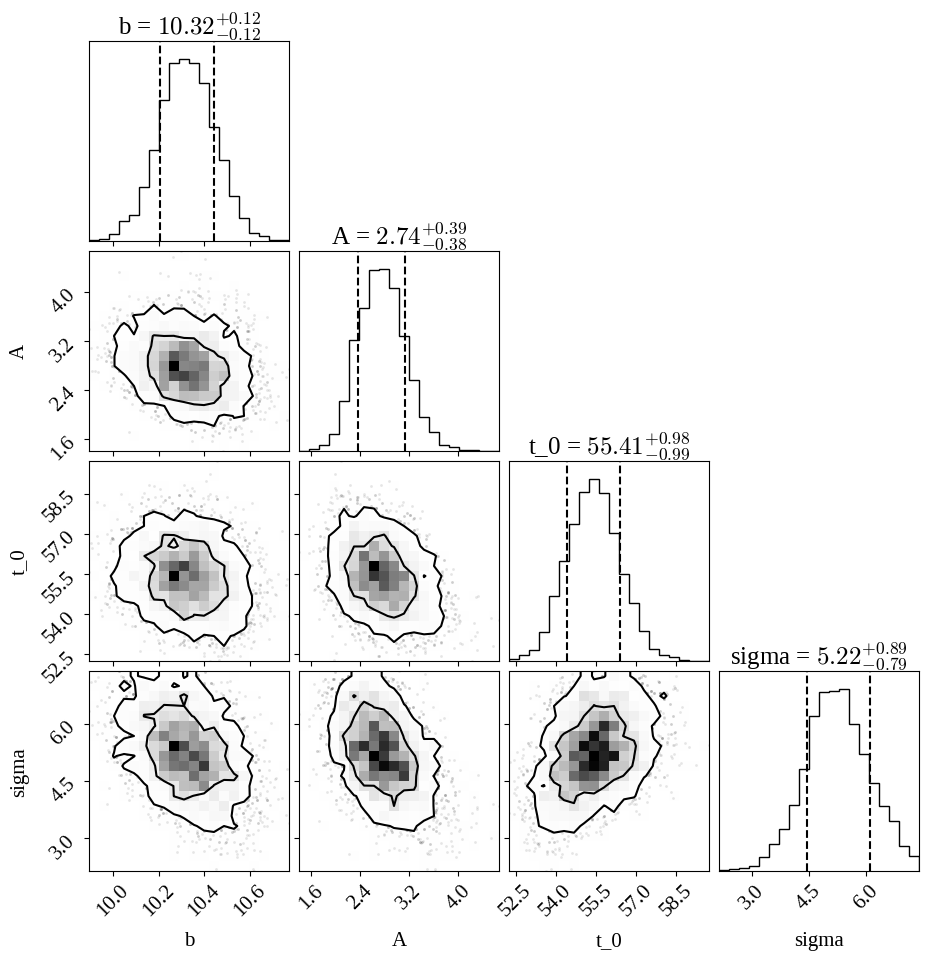

In [18]:
fig = corner.corner(samples_eq_gauss, labels=labels_gauss, levels=[0.68,0.95], quantiles=[0.16, 0.84], show_titles=True)

In [19]:
quantiles_gauss = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights_gauss)
             for samps in samples_gauss.T]
for q,l in zip(quantiles_gauss,labels_gauss):
    low,med,up=q
    print(l,"=",str(round(med,2)),"+",str(round(up-med,2)),"-",str(round(med-low,2)))

b = 10.32 + 0.2 - 0.2
A = 2.74 + 0.65 - 0.58
t_0 = 55.41 + 1.62 - 1.58
sigma = 5.23 + 1.43 - 1.33


### Model comparison

We have now two models that describe our data: a burst model and a gaussian profile. Let's compare the two results to verify which one better describes the transient data.

First plot the posterior spread of the two models.

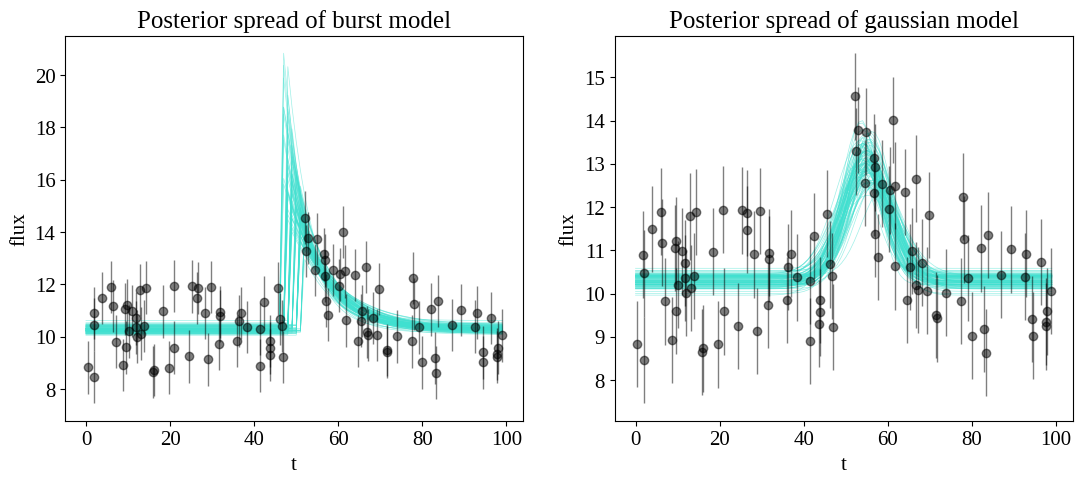

In [51]:
# model comparison

burst100 = samples_eq_burst[np.random.choice(range(len(samples_eq_burst)), 100)]
gauss100 = samples_eq_gauss[np.random.choice(range(len(samples_eq_gauss)), 100)]
t = np.linspace(0,100,100)

flux_burst_model = np.array([burst(par, t) for par in burst100])
flux_gauss_model = np.array([gauss_model(par, t) for par in gauss100])

fig = plt.figure(figsize=(13, 5))

ax=fig.add_subplot(121)

for i in range(len(flux_burst_model)):
    plt.plot(flux_burst_model[i], alpha=0.5, color='turquoise', lw=0.5)
    plt.title('Posterior spread of burst model')
    plt.xlabel('t')
    plt.ylabel('flux')

plt.errorbar(time, flux, err, lw=2, elinewidth=1, fmt='o', color='black', alpha=0.5)

ax=fig.add_subplot(122)

for i in range(len(flux_gauss_model)):
    plt.plot(flux_gauss_model[i], alpha=0.5, color='turquoise', lw=0.5)
    plt.title('Posterior spread of gaussian model')
    plt.xlabel('t')
    plt.ylabel('flux')

plt.errorbar(time, flux, err, lw=2, elinewidth=1, fmt='o', color='black', alpha=0.5)
plt.show()

Compute the Bayes factor of the two model to verify which one fits better the data.

In [49]:
evidence_burst = np.exp(result_burst.logz[-1])
evidence_gauss = np.exp(result_gauss.logz[-1])

Bayes_factor = evidence_burst/evidence_gauss

print(Bayes_factor)

# the burst model fits better the data

67.34036705159029


The **Burst model** better describes the data that we are observing.